# la Resting ECG de la clase dos es bernoulli! y la estamos tratando como multinomial

# Es mejor que cada una tenga su distribucion

In [52]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli, multinomial, gaussian_kde, shapiro, kstest, poisson

In [53]:
cleavland = pd.read_csv('05-heart+disease/processed.cleveland.data', header=None, encoding='ISO-8859-1')
hungary = pd.read_csv('05-heart+disease/processed.hungarian.data', header=None, encoding='ISO-8859-1')
switzerland = pd.read_csv('05-heart+disease/processed.switzerland.data', header=None, encoding='ISO-8859-1')
va = pd.read_csv('05-heart+disease/processed.va.data', header=None, encoding='ISO-8859-1')

In [54]:
attributes = ["Age", "Sex", "Chest Pain Type", "Resting Blood Pressure", "Cholesterol", "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Induced Angina", "ST Depression", "Slope", "Number of Major Vessels", "Thal", "Diagnosis of Heart Disease"]

cleavland.columns = attributes
hungary.columns = attributes
switzerland.columns = attributes
va.columns = attributes

In [55]:
df = pd.concat([cleavland, hungary, switzerland, va], ignore_index=True)

In [56]:
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

# sort df by class, later the Iwi[i] will be sorted by this order
df = df.sort_values(by=[df.columns[-1]])
df = df.reset_index(drop=True)

In [57]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

In [58]:
for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

In [59]:
for i in range(len(classes)):                   # For every class

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Poisson distribution
        if len(unique_values) < 10:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [60]:
def probability_categorical(attribute, value, Iwi):
    exitoIwi = len(Iwi[Iwi[attribute] == value])
    nIwi = len(Iwi)
    p = exitoIwi/nIwi
    return p

In [61]:
def diagnostic(age, sex, chest_pain_type, resting_blood_pressure, cholesterol, fasting_blood_sugar, resting_ecg, max_heart_rate, exercise_induced_angina, st_depression, slope, number_of_major_vessels, thal):

    Pwis = []

    for clase in range(len(classes)):

        # Tienen que ir adentro porque los de la clase 3 no tienen Chest Pain Type 1

        Page = pxjIwi[clase][0].pdf(age)
        Psex = probability_categorical("Sex", sex, Iwi[clase])
        Pcpt = probability_categorical("Chest Pain Type", chest_pain_type, Iwi[clase])
        Prbp = pxjIwi[clase][3].pdf(resting_blood_pressure)
        Pcho = pxjIwi[clase][4].pdf(cholesterol)
        Pfbs = probability_categorical("Fasting Blood Sugar", fasting_blood_sugar, Iwi[clase])
        Prec = probability_categorical("Resting ECG", resting_ecg, Iwi[clase])
        Pmhr = pxjIwi[clase][7].pdf(max_heart_rate)
        Peia = probability_categorical("Exercise Induced Angina", exercise_induced_angina, Iwi[clase])
        Pstd = pxjIwi[clase][9].pdf(st_depression)
        Pslo = probability_categorical("Slope", slope, Iwi[clase])
        Pnmv = probability_categorical("Number of Major Vessels", number_of_major_vessels, Iwi[clase])
        # Ptal = pxjIwi[clase][12].evaluate(thal)
        
        Pwi = pwi[clase] * Page * Psex * Pcpt * Prbp * Pcho * Pfbs * Prec * Pmhr * Peia * Pstd * Pslo * Pnmv # * Ptal

        if type(Pwi) == np.ndarray:
            Pwi = Pwi[0]
        Pwis.append(Pwi)

        # print(f"Diagnosis of heart disease {clase} is {Pwi}")

    argmax = np.argmax(Pwis)
    print(f"The most likely diagnosis is {argmax}")

    return argmax

# Backtesting

## For All

In [62]:
for clase in range(len(classes)):
    Iwi[clase] = Iwi[clase].sample(frac=1).reset_index(drop=True)   # Shuffle the rows

In [63]:
train = []
test = []

for clase in range(len(classes)):
    train.append(Iwi[clase].iloc[:  int(len(Iwi[clase])*0.8), :])   # 80% of the rows
    test.append(Iwi[clase].iloc[int(len(Iwi[clase])*0.8):, :])      # 20% of the rows

In [64]:
test[0].head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
128,57.0,1.0,4.0,132.0,207.0,0.0,0.0,168.0,1.0,0.0,1.0,0.0,7.0,0
129,51.0,0.0,3.0,120.0,295.0,0.0,2.0,157.0,0.0,0.6,1.0,0.0,3.0,0
130,64.0,0.0,3.0,140.0,313.0,0.0,0.0,133.0,0.0,0.2,1.0,0.0,7.0,0
131,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0
132,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0,0


# Get the values of the first row

In [65]:
# get the values of the first instance
diagnostic(*test[0].iloc[0, :-1]) # chat

The most likely diagnosis is 0


0

In [66]:
train[4]

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,58.0,1.0,4.0,114.0,318.0,0.0,1.0,140.0,0.0,4.4,3.0,3.0,6.0,4
1,64.0,1.0,4.0,145.0,212.0,0.0,2.0,132.0,0.0,2.0,2.0,2.0,6.0,4
2,58.0,1.0,3.0,112.0,230.0,0.0,2.0,165.0,0.0,2.5,2.0,1.0,7.0,4
3,63.0,0.0,4.0,150.0,407.0,0.0,2.0,154.0,0.0,4.0,2.0,3.0,7.0,4
4,57.0,1.0,4.0,165.0,289.0,1.0,2.0,124.0,0.0,1.0,2.0,3.0,7.0,4
5,77.0,1.0,4.0,125.0,304.0,0.0,2.0,162.0,1.0,0.0,1.0,3.0,3.0,4
6,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0,4
7,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4
8,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4
9,55.0,1.0,4.0,160.0,289.0,0.0,2.0,145.0,1.0,0.8,2.0,1.0,7.0,4


In [67]:
df = pd.concat([train[0], train[1], train[2], train[3], train[4]], ignore_index=True)
df

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,53.0,1.0,3.0,130.0,197.0,1.0,2.0,152.0,0.0,1.2,3.0,0.0,3.0,0
1,48.0,1.0,3.0,124.0,255.0,1.0,0.0,175.0,0.0,0.0,1.0,2.0,3.0,0
2,47.0,1.0,3.0,138.0,257.0,0.0,2.0,156.0,0.0,0.0,1.0,0.0,3.0,0
3,46.0,0.0,2.0,105.0,204.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0
4,52.0,1.0,2.0,134.0,201.0,0.0,0.0,158.0,0.0,0.8,1.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,77.0,1.0,4.0,125.0,304.0,0.0,2.0,162.0,1.0,0.0,1.0,3.0,3.0,4
234,61.0,1.0,4.0,138.0,166.0,0.0,2.0,125.0,1.0,3.6,2.0,1.0,3.0,4
235,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4
236,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,4


In [68]:
classes = df.iloc[:, -1].unique() # M
total = len(df)                   # N
attributes = df.columns           # X_i i \in {1, 2, ...}

Iwi = []        # Table of instances for each class
pwi = []        # a priori probability
pxjIwi = []     # p(X_j|w_i) for each class

In [69]:
for i in range(len(classes)):                   # For every class

    Iwi.append(df[df.iloc[:, -1] == classes[i]])         # Append the instances of the class
    pwi.append(len(Iwi[i])/total)               # Append the a priori probability
    
    pxjIwi.append([])                           # Append an empty list for the conditional probability - chat

In [70]:
for i in range(len(classes)):                   # For every class

    for attribute in attributes[:-1]:        # For every attribute except the last one (target variable)

        unique_values = Iwi[i][attribute].unique()

        # Poisson distribution
        if len(unique_values) < 6:
        # Test if the attribute is Poisson distributed
            mean = Iwi[i][attribute].mean()
            ks_test = kstest(Iwi[i][attribute], 'poisson', args=(mean,))    # - test if the attribute is Poisson distributed
            if ks_test.pvalue > 0.05:
                lambda_ = Iwi[i][attribute].mean()  # Calculate the mean
                un_pxiIwi = poisson(lambda_)            # Create a Poisson distribution

        # Multinomial distribution

        # Normal distribution
        else: 
            shapiro_test = shapiro(Iwi[i][attribute])
            if shapiro_test.pvalue > 0.05:
                xbar = Iwi[i][attribute].mean()
                s = Iwi[i][attribute].std()
                un_pxiIwi = norm(xbar, s)             # Create a Normal distribution

        # KDE distribution
            else:
                un_pxiIwi = gaussian_kde(Iwi[i][attribute]) # Calculate the probability

        pxjIwi[i].append(un_pxiIwi)                    # Append the conditional probability

In [71]:
diagnostic(*test[0].iloc[0, :-1]) # chat. The * unpacks the values of the row, so it's like diagnostic(test[0].iloc[0, 0], test[0].iloc[0, 1], ...)

The most likely diagnosis is 0


0

In [72]:
alltest = pd.concat([test[0], test[1], test[2], test[3], test[4]], ignore_index=True)
alltest

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease
0,57.0,1.0,4.0,132.0,207.0,0.0,0.0,168.0,1.0,0.0,1.0,0.0,7.0,0
1,51.0,0.0,3.0,120.0,295.0,0.0,2.0,157.0,0.0,0.6,1.0,0.0,3.0,0
2,64.0,0.0,3.0,140.0,313.0,0.0,0.0,133.0,0.0,0.2,1.0,0.0,7.0,0
3,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0
4,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,68.0,1.0,3.0,180.0,274.0,1.0,2.0,150.0,1.0,1.6,2.0,0.0,7.0,3
57,49.0,1.0,3.0,120.0,188.0,0.0,0.0,139.0,0.0,2.0,2.0,3.0,7.0,3
58,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4
59,60.0,1.0,4.0,130.0,206.0,0.0,2.0,132.0,1.0,2.4,2.0,2.0,7.0,4


In [73]:
predictions = []

for i in range(len(alltest)):
    predictpredict = diagnostic(*alltest.iloc[i, :-1])
    predictions.append(predictpredict)

The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 2
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 1
The most likely diagnosis is 1
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 1
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most likely diagnosis is 0
The most

In [74]:
# add the predictions to the dataframe
alltest["PREDICT PREDICT"] = predictions
alltest

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,ST Depression,Slope,Number of Major Vessels,Thal,Diagnosis of Heart Disease,PREDICT PREDICT
0,57.0,1.0,4.0,132.0,207.0,0.0,0.0,168.0,1.0,0.0,1.0,0.0,7.0,0,0
1,51.0,0.0,3.0,120.0,295.0,0.0,2.0,157.0,0.0,0.6,1.0,0.0,3.0,0,0
2,64.0,0.0,3.0,140.0,313.0,0.0,0.0,133.0,0.0,0.2,1.0,0.0,7.0,0,0
3,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,0,0
4,51.0,1.0,3.0,110.0,175.0,0.0,0.0,123.0,0.0,0.6,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,68.0,1.0,3.0,180.0,274.0,1.0,2.0,150.0,1.0,1.6,2.0,0.0,7.0,3,1
57,49.0,1.0,3.0,120.0,188.0,0.0,0.0,139.0,0.0,2.0,2.0,3.0,7.0,3,0
58,50.0,1.0,4.0,150.0,243.0,0.0,2.0,128.0,0.0,2.6,2.0,0.0,7.0,4,1
59,60.0,1.0,4.0,130.0,206.0,0.0,2.0,132.0,1.0,2.4,2.0,2.0,7.0,4,3


[[28  3  1  0  0]
 [ 6  2  1  2  1]
 [ 0  3  1  2  1]
 [ 2  2  1  2  0]
 [ 0  1  1  1  0]]


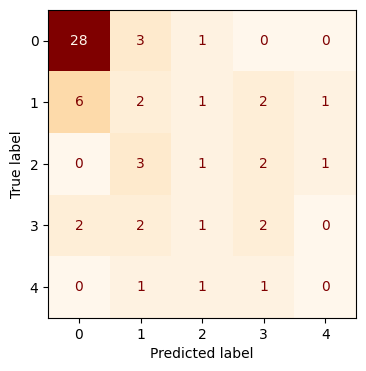

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# True labels
y_true = alltest.iloc[:, -2] 

# Predicted labels
y_pred = alltest.iloc[:, -1]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap="OrRd", ax=ax, colorbar=False)
plt.show()

In [76]:
from sklearn import metrics

# Balanced accuracy
metrics.balanced_accuracy_score(y_true, y_pred)

0.29404761904761906

In [77]:
# Precision
metrics.precision_score(y_true, y_pred,
                        average=None)

array([0.77777778, 0.18181818, 0.2       , 0.28571429, 0.        ])

In [78]:
# Recall
metrics.recall_score(y_true, y_pred,
                     average=None)

array([0.875     , 0.16666667, 0.14285714, 0.28571429, 0.        ])

In [79]:
# F1-score
metrics.f1_score(y_true, y_pred,
                 average=None)

array([0.82352941, 0.17391304, 0.16666667, 0.28571429, 0.        ])

In [80]:
#F-beta score
beta_1 = metrics.fbeta_score(y_true, y_pred,
                    average=None,
                    beta=1)
beta_2 = metrics.fbeta_score(y_true, y_pred,
                    average=None,
                    beta=.1)
print("beta=1", beta_1)
print("beta=2", beta_2)

beta=1 [0.82352941 0.17391304 0.16666667 0.28571429 0.        ]
beta=2 [0.77863436 0.18165468 0.19921105 0.28571429 0.        ]


### Classification report

In [81]:
from sklearn.metrics import classification_report

# Display classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.18      0.17      0.17        12
           2       0.20      0.14      0.17         7
           3       0.29      0.29      0.29         7
           4       0.00      0.00      0.00         3

    accuracy                           0.54        61
   macro avg       0.29      0.29      0.29        61
weighted avg       0.50      0.54      0.52        61

